In [45]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import Markdown
import pandas as pd
import xgboost as xgb
import numpy as np
import graphviz as gr
import seaborn as sns
from matplotlib import pyplot as plt
import econml
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, roc_auc_score


import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
#Import estimation functions
import sys
import os

module_path = os.path.abspath(os.path.join('..', 'E2E_Self_Serve_CI_Tool', 'diice'))
if module_path not in sys.path:
    sys.path.append(module_path)


from estimation import propensity_functions, causal_functions

### Testing Datasets

In [3]:
# 401k dataset + loaded DAG

# 1991 Survey of Income and Program Participation (401k) - very small weight for treatment (net_tfa) from discovery
file = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/401k.csv"
data = pd.read_csv(file)

#load learned DAG
W_avg = np.loadtxt(r'C:\Users\tomle\OneDrive\Documents\Projects\Causal-Inference\E2E_Self_Serve_CI_Tool\learned_dag_401k_dagma_NL.txt', dtype=np.float64)

#colnames
t = 'e401'
select_data = data[data.columns[:-12]]
# select_data = data.loc[:, data.nunique() > 2]
select_data[t] = data[t]
col_names = select_data.columns
data.head()

,ira,a401,hval,hmort,hequity,nifa,net_nifa,tfa,net_tfa,tfa_he,tw,age,inc,fsize,educ,db,marr,male,twoearn,dum91,e401,p401,pira,nohs,hs,smcol,col,icat,ecat,zhat,net_n401,hown,i1,i2,i3,i4,i5,i6,i7,a1,a2,a3,a4,a5
0,0,0,69000,60150,8850,100,-3300,100,-3300,5550,53550,31,28146,5,12,0,1,0,0,1,0,0,0,0,1,0,0,3,2,0.273178,-3300,1,0,0,1,0,0,0,0,0,1,0,0,0
1,0,0,78000,20000,58000,61010,61010,61010,61010,119010,124635,52,32634,5,16,0,0,0,0,1,0,0,0,0,0,0,1,4,4,0.386641,61010,1,0,0,0,1,0,0,0,0,0,0,1,0
2,1800,0,200000,15900,184100,7549,7049,9349,8849,192949,192949,50,52206,3,11,0,1,1,1,1,0,0,1,1,0,0,0,6,1,0.533650,8849,1,0,0,0,0,0,1,0,0,0,0,1,0
3,0,0,0,0,0,2487,-6013,2487,-6013,-6013,-513,28,45252,4,15,0,1,0,1,1,0,0,0,0,0,1,0,5,3,0.324319,-6013,0,0,0,0,0,1,0,0,1,0,0,0,0
4,0,0,300000,90000,210000,10625,-2375,10625,-2375,207625,212087,42,33126,3,12,1,0,0,0,1,0,0,0,0,1,0,0,4,2,0.602807,-2375,1,0,0,0,1,0,0,0,0,0,1,0,0


In [4]:
# Athey, Wager (2019) Estimating Treatment Effects with Causal Forests: An Application syntheic data (National Study of Learning Mindsets)
file = "datasets/athey_mindset_synthetic_data.csv"
data = pd.read_csv(file, encoding='utf-8')
data.head()

,schoolid,Z,Y,S3,C1,C2,C3,XC,X1,X2,X3,X4,X5
0,76,1,0.081602,6,4,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
1,76,1,-0.385869,4,12,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
2,76,1,0.398184,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
3,76,1,-0.175037,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
4,76,1,0.884583,6,4,1,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757


In [5]:
#metadata for above
"""
Attached is a dataset of about 10,000 students in 76 schools with a simulated outcome Y (a continuous measure of achievement), a binary treatment variable Z indicating receipt of the intervention, and the following 10 covariates at both the student and school level:

S3 - Students' self-reported expectations for success in the future, a proxy for prior achievement, measured prior to random assignment
C1 - Categorical variable for student race/ethnicity
C2 - Categorical variable for student identified gender
C3 - Categorical variable for student first-generation status (i.e. first in family to go to college)
XC - School-level categorical variable for urbanicity of the school (i.e. rural, suburban, etc.)
X1 - School-level mean of students' fixed mindsets, reported prior to random assignment
X2 - School achievement level, as measured by test scores and college preparation for the previous 4 cohorts of students
X3 - School racial/ethnic minority composition -- i.e. % black, latino, or native/american
X4 - School poverty concentration -- i.e. % of students who are from families whose incomes fall below the federal poverty line
X5 - School size - Total # of students in all four grade levels in the school


The main research questions to be addressed include:

Was the mindset intervention effective in improving student achievement?
Researchers hypothesize that the effect of the intervention is moderated by school level achievement (X2) and pre-existing mindset norms (X1). In particular there are two competing hypotheses about how X2 moderates the effect of the intervention: Either it is largest in middle-achieving schools (a "Goldilocks effect") or is decreasing in school-level achievement
Researchers also collected other covariates and are interested in exploring their possible role in moderating treatment effects.
"""

'\nAttached is a dataset of about 10,000 students in 76 schools with a simulated outcome Y (a continuous measure of achievement), a binary treatment variable Z indicating receipt of the intervention, and the following 10 covariates at both the student and school level:\n\nS3 - Students\' self-reported expectations for success in the future, a proxy for prior achievement, measured prior to random assignment\nC1 - Categorical variable for student race/ethnicity\nC2 - Categorical variable for student identified gender\nC3 - Categorical variable for student first-generation status (i.e. first in family to go to college)\nXC - School-level categorical variable for urbanicity of the school (i.e. rural, suburban, etc.)\nX1 - School-level mean of students\' fixed mindsets, reported prior to random assignment\nX2 - School achievement level, as measured by test scores and college preparation for the previous 4 cohorts of students\nX3 - School racial/ethnic minority composition -- i.e. % black, l

In [6]:
# # Customer Purchase Propensity Dataset - for testing poorness of propensity model results on small datasets (like the mindset dataset)
# file = "datasets/training_sample.csv"
# data = pd.read_csv(file, encoding='utf-8')
# data.head()

### Estimator Classes Testing

In [89]:
#Classes

class PropensityBasedEstimation():
    
    """
    Main class for propensity methods (Matching, Inverse Propensity Weighting). Instances of this class will take the input data (i.e. adjustment set from the identification module) perform sample splitting (only supports 2 splits for now) and cross fit propensity models to each split. Propensity method(s) can then be called (currently supports matching and IPW) and predicted values are saved to the instance. They can then be used to estimate the ATE, balance groups, and perform EDA (i.e. assess positivity/propensity overlap), etc.

    Parameters
    ----------
    data : pd.DataFrame
        The input data as a pandas dataframe containing X, T, and Y.
    treatment : str
        Name of the treatment column in the input data. Currently only supports binary treatments.
    outcome: str
        Name of the outcome column in the input data. Supports binary and continous outcomes.
    col_names : list
        List of feature names to be included in X (covariates).
    prop_model_algo : str
        The algorithm to use for the propensity model. Currently only supports 'xgb' (XGBoost).
    seed : int
        Random seed for reproducibility.

    Attributes
    ----------
    
    
    
    """

    def __init__(self, data: pd.DataFrame, treatment: str, outcome: str, col_names: list, prop_model_algo='xgb', seed=2025):
        self.data = data
        self.treatment = treatment
        self.outcome = outcome
        self.col_names = col_names
        self.prop_model_algo = prop_model_algo
        self.seed = seed
        self.split_data = self._sample_split()
        self.prop_models, self.prop_scores = None, None
        self.prop_models, self.prop_scores = self._propensity_modeling()
        self.matched_data = None
        self.ate_estimates = {}
        self.cate_estimates = {}

    def _sample_split(self):
        """
        Split the input data into two samples for cross fitting. Stratifies on T or T + Y if binary outcome.
        """
        df = self.data
        treatment = self.treatment
        outcome = self.outcome
        col_names = self.col_names

        #stratify on T only, if outcome is continous
        if df[outcome].nunique() > 2:
            df['stratify_var'] = df[treatment]
        else:
            # Create a combined stratification variable if outcome is binary
            df['stratify_var'] = df[treatment].astype(str) + '_' + df[outcome].astype(str)

        x, t, y, idx = df, df[treatment], df[outcome], df.index
        x_a, x_b, t_a, t_b, y_a, y_b, idx_a, idx_b = train_test_split(
            x, t, y, idx,
            test_size=0.5,
            stratify=x['stratify_var'],
            random_state=self.seed
        )

        x_a = x_a[col_names]
        x_b = x_b[col_names]

        return [(x_a, t_a, y_a, idx_a),(x_b, t_b, y_b, idx_b)]

    def _propensity_modeling(self, params=None, predict_on_same_split=False):
        """
        Cross-fit propensity models and use out of sample predictions as the propensity scores.

        Parameters
        ----------
        params : dict
            Parameters for the propensity model. Use default values unless there is very good reason to change them (i.e. additionally reduce overfitting)
        predict_on_same_split : bool
            Whether to predict on the same split that was used to fit model. Default is False, only override if cross-fitting performance is excessively poor (i.e. AUC < 0.6 or PR-AUC ~= positive class proportion)
        """

        df = self.data
        treatment = self.treatment

        #Cross fit propensity models
        if params is None:
            params = {
                'n_estimators': 1000,
                'max_depth': 4,
                'learning_rate': 0.1,
                'subsample': 0.8,
                'colsample_bytree': 0.8,
                'gamma': 1.0,
                'scale_pos_weight': (df[treatment].shape[0] - df[treatment].sum()) / df[treatment].sum(),
                'min_child_weight': 3.0,
                'reg_alpha': 0.1,
                'reg_lambda': 1.0,
                'random_state': self.seed,
                'n_jobs': -1,
            }
        else:
            params = params

        if self.prop_model_algo == 'xgb':
            prop_models = []
            for xi, ti, *_ in self.split_data:
                model = xgb.XGBClassifier(**params)
                model.fit(xi.values, ti.values)
                prop_models.append(model)
        
        #Generate out of sample predictions as propensity score and update the stored split data. Default is to predict on the split that wasn't used for training, but can be overriden to predict on the same split if cross-fitting performance is poor (i.e. overfitting due to small data size)

        if not predict_on_same_split:
            #Predict on the other split
            g_hat_a = prop_models[1].predict_proba(self.split_data[0][0].values)[:,1]
            g_hat_b = prop_models[0].predict_proba(self.split_data[1][0].values)[:,1]
        else:
            #Predict on the same split
            g_hat_a = prop_models[0].predict_proba(self.split_data[0][0].values)[:,1]
            g_hat_b = prop_models[1].predict_proba(self.split_data[1][0].values)[:,1]
            
        prop_scores = [g_hat_a, g_hat_b]

        #Check quality of propensity models using AUC and PR-AUC
        print('Positive class proportion in data: ', df[treatment].mean())
        print('Model A PR-AUC: ', average_precision_score(self.split_data[1][1],prop_scores[1]), '| Model A AUC: ', roc_auc_score(self.split_data[1][1],prop_scores[1]))
        print('Model B PR-AUC: ', average_precision_score(self.split_data[0][1],prop_scores[0]), '| Model B AUC: ', roc_auc_score(self.split_data[0][1],prop_scores[0]))

        #Plot propensity score distributions for treated vs untreated
        plt.close()
        fig, ax = plt.subplots()

        x_a = self.split_data[0][0]
        x_b = self.split_data[1][0]
        x_a['g_hat'] = g_hat_a
        x_b['g_hat'] = g_hat_b
        x_a[treatment] = self.split_data[0][1]
        x_b[treatment] = self.split_data[1][1]
        x = pd.concat([x_a, x_b])

        fig.suptitle('Treated vs. Untreated Propensity Distributions')
        sns.kdeplot(data = x[x[treatment]==1], x = 'g_hat',  ax = ax, label = 'treated').set()
        sns.kdeplot(data = x[x[treatment]==0], x = 'g_hat',  ax = ax, color='orange', label = 'untreated')
        plt.legend()
        plt.show()

        x_a.drop(columns=[treatment, 'g_hat'], inplace=True)
        x_b.drop(columns=[treatment, 'g_hat'], inplace=True)

        #return models and scores to initialized instance variables if first time running, otherwise update instance variables with new models and scores for re-runs
        if self.prop_models is None:
            if self.prop_scores is None:
                return prop_models, prop_scores
        else:
            self.prop_models = prop_models
            self.prop_scores = prop_scores

    def match(self, caliper_scale='propensity', caliper=0.03, replace=False, save_matched_data=True):
        """
        Perform matching on the treated and untreated samples using the propensity scores. The caliper parameter is the maximum difference of propensity (either absolute or logit) to be matched, while caliper_scale specifies whether the caliper is an absolute difference in propensity scores or a fraction of the standard deviation of the log-transformed propensity scores. 

        Parameters
        ----------
        caliper_scale : str, optional
            "propensity" (default) if caliper is a maximum difference in propensity scores,
            "logit" if caliper is a maximum SD of log-transformed propensity scores, or
            None for no caliper.
        caliper : float, optional
            Specifies maximum distance (difference in propensity scores or SD of log-transformed propensity scores).
            Default is 0.03.
        replace : bool, optional
            Should individuals from the larger group be allowed to match multiple individuals in the smaller group?
            Default is False.
        save_matched_data : bool, optional
            Whether to save the matched data to the instance variable. Default is True.
        """

        x_a = self.split_data[0][0]
        x_b = self.split_data[1][0]
        x_a['g_hat'] = self.prop_scores[0]
        x_b['g_hat'] = self.prop_scores[1]
        x_a[self.treatment] = self.split_data[0][1]
        x_b[self.treatment] = self.split_data[1][1]
        x_a[self.outcome] = self.split_data[0][2]
        x_b[self.outcome] = self.split_data[1][2]
        df = pd.concat([x_a, x_b]).sort_index()
        
        #set seed here for reproducibility of results
        np.random.seed(self.seed)

        #Create matched data
        treatment = df[self.treatment]
        pscore = df['g_hat']
        match = propensity_functions.Match(treatment,pscore)
        match.create(method='one-to-one', caliper_scale=caliper_scale, caliper=caliper, replace=replace)
        data_matched = propensity_functions.whichMatched(match, df, show_duplicates = False)
        
        x_a.drop(columns=[self.treatment, 'g_hat', self.outcome], inplace=True)
        x_b.drop(columns=[self.treatment, 'g_hat', self.outcome], inplace=True)

        if save_matched_data:
            #Save matched data to instance variable
            self.matched_data = data_matched
        else:
            return data_matched
        
    def check_match_quality(self, features_to_check=None, log_scale=False):
        """
        Check the quality of the matching by comparing the distribution of a feature before and after matching using KDE plots and statistical tests.

        Parameters
        ----------
        data : pd.DataFrame
            Full input data before matching.
        data_matched : pd.DataFrame
            Matched data.
        treatment : str
            Name of the treatment column in the data.
        feature : list
            A list of features to compare. If None (default), all features (covariates) will be compared.
        log_scale : bool, optional
            Whether to log-transform feature list before comparing. Default is False.
        """
        df = self.data
        df_matched = self.matched_data
        treatment = self.treatment

        if features_to_check is None:
            features = self.col_names
        else:
            features = features_to_check

        #Visual inspection
        if log_scale:
            #handle division by 0
            df[features] = df[features].replace(0,0.1)
            df_matched[features] = df_matched[features].replace(0,0.1)

        for feature in features:
            propensity_functions.comparison_plot(df,df_matched, treatment, feature, log_scale=True)
            try: 
                propensity_functions.comparison_stat_tests(df_matched, treatment, feature)
            except:
                pass
    
    def s_learner(self, estimation_type=None, se_type=None,params=None):
        """
        Function for S-learner with IPW.

        """
        df = self.data
        split_data = self.split_data
        prop_scores = self.prop_scores
        features = self.col_names
        treatment = self.treatment
        outcome = self.outcome
        estimation_type = estimation_type
        se_type = se_type

        #Estimation using cross-fitting
        for split in range(len(split_data)):
            print(f'Estimating using split {"A" if split == 0 else "B"} of data')
            not_split = int(not split)
            
            #Get indicies for each split of data to pull them from original df
            idx = split_data[split][-1]
            not_idx = split_data[not_split][-1]
            dfi = df.loc[idx]
            dfi_n = df.loc[not_idx]
            g_hat_i = prop_scores[split]    
            
            # Create S Learner

            #sample weights created using the ω function to calculate inverse propensity weights to further reduce confounding
            print("about create S Learner", flush=True)

            #initialize default params (xgboost)
            if params is None:
                if estimation_type == 'linear':
                    params={}
                else:
                    if df[outcome].nunique() > 2:
                        eval_metric='rmse'
                    else:
                        eval_metric='aucpr'
                    
                    params={
                        'n_estimators': 500,
                        'max_depth': 5,
                        'learning_rate': 0.1,
                        'subsample': 0.8,
                        'colsample_bytree': 0.8,
                        'scale_pos_weight': (df[treatment].shape[0] - df[treatment].sum()) / df[treatment].sum(),
                        'min_child_weight': 15,
                        'reg_alpha': 0.5,
                        'reg_lambda': 2.0,
                        'eval_metric': eval_metric,
                        'random_state': self.seed,
                        'n_jobs': -1,
                    }
            else:
                params = params
                

            if df[outcome].nunique() > 2:
                if estimation_type == 'linear':
                    s_model = LinearRegression(**params).fit(
                        dfi[features+[treatment]].values, dfi[outcome].values, 
                        sample_weight=causal_functions.ω(g_hat_i, dfi[treatment].values)
                    )
                else:
                    s_model = xgb.XGBRegressor(**params).fit(
                        dfi[features+[treatment]].values, dfi[outcome].values, 
                        sample_weight=causal_functions.ω(g_hat_i, dfi[treatment].values)
                    )
            else:
                if estimation_type == 'linear':
                    s_model = LogisticRegression(**params).fit(
                        dfi[features+[treatment]].values, dfi[outcome].values, 
                        sample_weight=causal_functions.ω(g_hat_i, dfi[treatment].values)
                    )
                else:
                    s_model = xgb.XGBClassifier(**params).fit(
                        dfi[features+[treatment]].values, dfi[outcome].values, 
                        sample_weight=causal_functions.ω(g_hat_i, dfi[treatment].values)
                    )
            # Estimate potential outcomes
            
            if df[outcome].nunique() > 2:
                ##### Regression #####

                # Estimate CATE from total data, using model trained on one half
                x0, x1 = causal_functions.get_potential_outcome_df(df, treatment, features)
                ψi = s_model.predict(x1) - s_model.predict(x0)

                # Estimate CATE from in sample data (i.e. data used to train outcome model above)
                x0, x1 = causal_functions.get_potential_outcome_df(dfi, treatment, features)
                ψ_is = s_model.predict(x1) - s_model.predict(x0)

                # Estimate CATE from out of sample data (i.e. the other fold)
                x0, x1 = causal_functions.get_potential_outcome_df(dfi_n, treatment, features)
                ψ_oos = s_model.predict(x1) - s_model.predict(x0)

            else:
                ##### Classification #####

                # Estimate CATE from total data, using model trained on one half
                x0, x1 = causal_functions.get_potential_outcome_df(df, treatment, features)
                ψi = s_model.predict_proba(x1)[:,1] - s_model.predict_proba(x0)[:,1]

                # Estimate CATE from in sample data (i.e. data used to train outcome model above)
                x0, x1 = causal_functions.get_potential_outcome_df(dfi, treatment, features)
                ψ_is = s_model.predict_proba(x1)[:,1] - s_model.predict_proba(x0)[:,1]

                # Estimate CATE from out of sample data (i.e. the other fold)
                x0, x1 = causal_functions.get_potential_outcome_df(dfi_n, treatment, features)
                ψ_oos = s_model.predict_proba(x1)[:,1] - s_model.predict_proba(x0)[:,1]

                # #Evaluate outcome model performance on out of sample data (i.e. the other fold)
                # oos_predict_proba = s_model.predict_proba(dfi_n[features + [treatment]])[:,1]
                # oos_pr_auc = average_precision_score(dfi_n[outcome].values, oos_predict_proba)
                # print('oos positive class prevalence: ', dfi_n[outcome].mean())
                # print('outcome model PRAUC on other fold: ', oos_pr_auc)
                
            #print results
            print(f'ψ_total = {ψi.mean():.5f} | ψ_in_sample = {ψ_is.mean():.5f} | ψ_out_of_sample = {ψ_oos.mean():.5f} ')

            #adding standard errors - calculated using oos in alignment with cross-fitting
            #approximate calculation
            if se_type == 'approximate':
                se = causal_functions.τ_se(s_model, dfi_n[outcome], dfi_n[dfi_n[treatment]==1][features + [treatment]], dfi_n[dfi_n[treatment]==0][features + [treatment]], ψ_oos, dfi_n[treatment])
                print('oos 95% CIs: ', ψ_oos.mean() - se*1.96, '|', ψ_oos.mean() + se*1.96)
                print('='*30)

            return ψ_oos.mean(), ψ_oos


    def ipw_estimation(self, method='s-learner', estimation_type='non-linear', estimator_params=None, se_type='approximate', save_results=True):
        """
        Estimate the (Conditional) Average Treatment Effect using Inverse Propensity Weighting (IPW) and an estimation method (currently supports linear and non-linear meta-learners).

        Parameters
        ----------
        method : str, optional
            The meta-learning method to use for estimation. Default is 's-learner'. Also supports 'x-learner'.
        estimation_type : str, optional
            The type of estimation to fit the data, supports linear and non-linear (default).
        estimator_params : dict, optional
            Params for the estimator. Keep as None unless you have good reason to tune the default params.
        se_type : str, optional
            How standard errors should be calculated. Default is 'approximate', which uses an analytical formula, or 'bootstrap' for bootstrapping estimation.
        save_results : bool, optional
            Whether to save the results to the instance variable. Default is True.
        """
        estimation_type = estimation_type

        #Estimate CATE/ATE with IPW methods:
        if method == 's-learner':
            ate, cate = self.s_learner(se_type=se_type, estimation_type=estimation_type, params=estimator_params)
            if save_results:
                self.ate_estimates['s_learner'] = ate
                self.cate_estimates['s_learner'] = cate
            else:
                return ate, cate

In [70]:
# mindset_prop.data[mindset_prop.data['Z']==1]

Positive class proportion in data:  0.3256664421133673
Model A PR-AUC:  0.3288237096567469 | Model A AUC:  0.5041731266934378
Model B PR-AUC:  0.3241087996673822 | Model B AUC:  0.5042488066628469


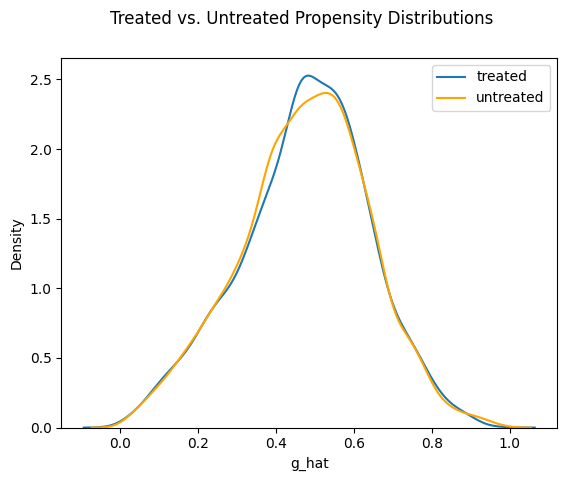

In [71]:
mindset_prop = PropensityBasedEstimation(data, 'Z', 'Y', ['S3', 'C1', 'C2', 'C3', 'XC', 'X1', 'X2', 'X3', 'X4', 'X5'], seed=2025)

Positive class proportion in data:  0.3256664421133673
Model A PR-AUC:  0.6191376253251774 | Model A AUC:  0.773107077220765
Model B PR-AUC:  0.6445118331063594 | Model B AUC:  0.7825894252073029


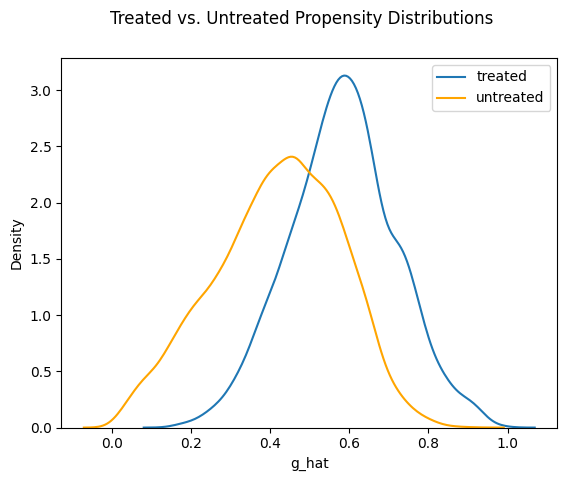

In [86]:
#if propensity model is poor, can re-run with predict_on_same_split=True
mindset_prop._propensity_modeling(predict_on_same_split=True)

In [79]:
#perform matching
mindset_prop.match(caliper_scale='propensity', caliper=0.03, replace=False, save_matched_data=True)

In [80]:
#check match count - should be 50% for 1:1 matching
mindset_prop.matched_data.Z.sum()/mindset_prop.matched_data.Z.count()

0.5

#### Match Quality Methods Testing

In [81]:
# #Visual inspection of matching quality - Checked and its good now
# mindset_prop.check_match_quality(log_scale=False)

In [88]:
mindset_prop.ipw_estimation(estimation_type='non-linear',save_results=True)

Estimating using split A of data
about create S Learner
ψ_total = 0.23313 | ψ_in_sample = 0.23408 | ψ_out_of_sample = 0.23219 
p:  0.325635103926097
vartau: 0.042950746
reached except block
yhat_given_1: [ 0.22553556  0.50709796 -0.36778283 ...  1.1748127  -0.44144544
 -0.02237798]
yhat_given_0: [-0.56441706  0.34270406 -0.5640904  ... -0.00310739 -0.4356818
  0.34270406]
var_treatment: 0.2791306911789168
var_control: 0.29040137840495633
oos 95% CIs:  0.2008239501383125 | 0.263557923469323
Estimating using split B of data
about create S Learner
ψ_total = 0.25496 | ψ_in_sample = 0.25484 | ψ_out_of_sample = 0.25508 
p:  0.3256977863330125
vartau: 0.038547914
reached except block
yhat_given_1: [ 0.02171027 -0.61408705  0.21977405 ...  1.1457396  -1.3491069
 -0.56727797]
yhat_given_0: [-0.6468067   0.22470367 -0.21550144 ...  0.5274929  -0.7969491
 -0.05110066]
var_treatment: 0.3025291439351132
var_control: 0.2887445454916222
oos 95% CIs:  0.22295155158123564 | 0.2872022188655417


,S3,C1,C2,C3,XC,X1,X2,X3,X4,X5,g_hat,Z,Y,weights,frequency
0,6,4,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757,0.576816,1,0.081602,1.0,1.0
1,4,12,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757,0.364856,1,-0.385869,1.0,1.0
3,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757,0.413987,1,-0.175037,1.0,1.0
4,6,4,1,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757,0.652071,1,0.884583,1.0,1.0
5,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757,0.732413,1,-0.090565,1.0,1.0


0.22449365178115727

-0.12958439589145382

In [130]:
# used to test why cross-fitting performance was poor, turns out it was due to small data size
# test_class = PropensityBasedEstimation(data, 'ordered', 'ordered', data.columns[1:-1], seed=2025)

In [ ]:

# # params = {
# #     'n_estimators': 1000,
# #     'max_depth': 4,
# #     'learning_rate': 0.1,
# #     'subsample': 0.8,
# #     'colsample_bytree': 0.8,
# #     'gamma': 1.0,
# #     'scale_pos_weight': 2,
# #     'min_child_weight': 3.0,
# #     'reg_alpha': 0.1,
# #     'reg_lambda': 1.0,
# #     #'early_stopping_rounds': 10,
# #     'random_state': 42,
# #     'n_jobs': -1,
# # }

# params = {}

# x, t = data[['S3', 'C1', 'C2', 'C3', 'XC', 'X1', 'X2', 'X3', 'X4', 'X5']], data['Z']
# x1, x2, t1, t2 = train_test_split(x, t, test_size=0.01, stratify=t, random_state=42)
# print(x1.shape, x2.shape)

# test = LogisticRegression(**params, random_state=42)
# test.fit(x1,t1)
# y_pred = test.predict_proba(x1)[:,1]
# roc_auc_score(t1,y_pred)

(10287, 10) (104, 10)


0.5514116601653689